In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.dataset import *
from fastai.structured import *
from fastai.column_data import *

from math import ceil

from dateutil import parser

torch.cuda.set_device(0)

In [2]:
PATH = "/home/paperspace/data/dog-breed-identification/"
sz=224
arch=resnext101_64
batch_size=5

## Exploratory Analysis and Feature Engineering

In [3]:
!ls {PATH}

item_categories.csv  models	      sample_submission.csv  test.csv
items.csv	     sales_train.csv  shops.csv		     tmp


In [4]:
sample_subm = pd.read_csv(f'{PATH}sample_submission.csv')
display(sample_subm.tail())

,ID,item_cnt_month
214195,214195,0.5
214196,214196,0.5
214197,214197,0.5
214198,214198,0.5
214199,214199,0.5


In [5]:
item_categories = pd.read_csv(f'{PATH}item_categories.csv')
items = pd.read_csv(f'{PATH}items.csv')
shops = pd.read_csv(f'{PATH}shops.csv')
train = pd.read_csv(f'{PATH}sales_train.csv')
test = pd.read_csv(f'{PATH}test.csv')

In [6]:
display(item_categories.head())
display(items.head())
display(shops.head())
display(train.head())
display(test.head())

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [7]:
test['month'] = 11
test['year'] = 2015

In [8]:
test = test.drop('ID', axis=1)

In [9]:
train['month'] = train.date.apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y').month)

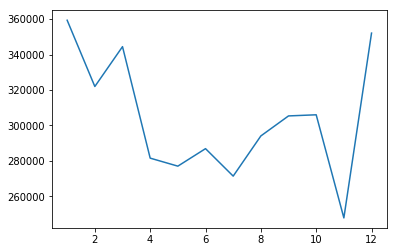

In [10]:
grouped = pd.DataFrame(train.groupby(['month'])['item_cnt_day'].sum().reset_index())
plt.plot(grouped['month'], grouped['item_cnt_day'])

In [11]:
train = train.set_index('item_id').join(items.set_index('item_id')).drop('item_name', axis=1).reset_index()
train['year'] = train.date.apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y').strftime('%Y'))
train = train.drop('date', axis=1)

In [12]:
test = test.set_index('item_id').join(items.set_index('item_id')).drop('item_name', axis=1).reset_index()

In [13]:
price = train.reset_index().set_index(['item_id', 'shop_id', 'date_block_num'])
price = price.sort_index()

In [14]:
train.isnull().any()

item_id             False
date_block_num      False
shop_id             False
item_price          False
item_cnt_day        False
month               False
item_category_id    False
year                False
dtype: bool

In [15]:
test['date_block_num'] = 0

In [16]:
pd.unique(test.date_block_num)

array([0])

In [17]:
def closest_date_block(current_day, item_id, shop_id):
    """Find the block_date which is closest to the current_day, given item_id and shop_id. Returns index integer"""
    if (item_id, shop_id) in price.index:
        search_lst = np.array(price.loc[(item_id, shop_id)].index)        
        return search_lst[np.abs(current_day - search_lst).argmin()]
    return -1
                
def closest_price(current_day, item_id, shop_id):
    closest_date = closest_date_block(current_day, item_id, shop_id)
    if closest_date != -1:
        return price.loc[( item_id, shop_id, closest_date )]['item_price'].iloc[0]
    return np.nan

counter = 0
def closest_price_lambda(x):
    global counter # hack, obviously this breaks if you use the lambda more than once
    if counter % 30000 == 0:
        print("{}/{}".format(counter, len(test)))
    counter += 1
    return closest_price(x['date_block_num'], x['item_id'], x['shop_id'])

In [18]:
test['item_price'] = test.apply(
    closest_price_lambda,
    axis=1,
)

0/214200
30000/214200
60000/214200
90000/214200
120000/214200
150000/214200
180000/214200
210000/214200


In [19]:
test['item_cnt_day'] = 0

In [20]:
train = train.set_index('item_id').reset_index()
test = test.set_index('item_id').reset_index()
columns =['item_id', 
          'date_block_num', 
          'shop_id',
          'item_price',
          'item_cnt_day',
          'month',
          'item_category_id',
          'year',
 ]
train = train[columns]
test = test[columns]

In [21]:
display(price.head())
display(train.head())
display(test.head())

index  item_price  item_cnt_day  month  \
item_id shop_id date_block_num                                           
0       54      20                  0        58.0           1.0      9   
1       55      15                  1      4490.0           1.0      4   
                15                  2      4490.0           1.0      4   
                18                  3      4490.0           1.0      7   
                19                  4      4490.0           1.0      8   

                                item_category_id  year  
item_id shop_id date_block_num                          
0       54      20                            40  2014  
1       55      15                            76  2014  
                15                            76  2014  
                18                            76  2014  
                19                            76  2014

,item_id,date_block_num,shop_id,item_price,item_cnt_day,month,item_category_id,year
0,0,20,54,58.0,1.0,9,40,2014
1,1,15,55,4490.0,1.0,4,76,2014
2,1,15,55,4490.0,1.0,4,76,2014
3,1,18,55,4490.0,1.0,7,76,2014
4,1,19,55,4490.0,1.0,8,76,2014


,item_id,date_block_num,shop_id,item_price,item_cnt_day,month,item_category_id,year
0,30,0,5,399.0,0,11,40,2015
1,30,0,4,399.0,0,11,40,2015
2,30,0,6,399.0,0,11,40,2015
3,30,0,3,399.0,0,11,40,2015
4,30,0,2,359.0,0,11,40,2015


# Training

## _Deep Learning Approach_

In [22]:
cat_vars = ['item_id', 'date_block_num',
            'shop_id', 'month', 'item_category_id', 'year']
contin_vars = ['item_price', 'item_cnt_day']
dep = 'item_cnt_day'

In [23]:
def rmse(y_pred, targ):
    return math.sqrt(((targ - y_pred)**2).mean())

In [24]:
test['item_cnt_day'] = 0

In [25]:
for v in cat_vars:
    train[v] = train[v].astype('category').cat.as_ordered()
    test[v] = test[v].astype('category').cat.as_ordered()
for v in contin_vars:
    train[v] = train[v].astype('float32')
    test[v] = test[v].astype('float32')

In [26]:
train.dtypes

item_id             category
date_block_num      category
shop_id             category
item_price           float32
item_cnt_day         float32
month               category
item_category_id    category
year                category
dtype: object

In [27]:
test.dtypes

item_id             category
date_block_num      category
shop_id             category
item_price           float32
item_cnt_day         float32
month               category
item_category_id    category
year                category
dtype: object

In [28]:
test['item_cnt_day'] = 0

In [31]:
df, y, nas, mapper = proc_df(train, 'item_cnt_day', do_scale=True)
test_df, _, nas, mapper = proc_df(
    test,
    'item_cnt_day',
    do_scale=True,
    mapper=mapper,
    na_dict=nas
)

In [32]:
train_ratio = 0.75
train_size = int(len(train) * train_ratio)
val_idx = list(range(train_size, len(df)))

In [33]:
trn_df = trn_df.sample(frac=1)

In [34]:
md = ColumnarModelData.from_data_frame(
    path=PATH,
    val_idxs=val_idx,
    df=df,
    y=y,
    cat_flds=cat_vars,
    bs=256,
    test_df=test_df
)

In [35]:
cat_sz = [(c, len(train[c].cat.categories)+1) for c in cat_vars]

In [36]:
cat_sz

[('item_id', 21808),
 ('date_block_num', 35),
 ('shop_id', 61),
 ('month', 13),
 ('item_category_id', 85),
 ('year', 4)]

In [100]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [ ]:
m = md.get_learner(
    emb_szs=emb_szs,
    n_cont=len(df.columns) - len(cat_vars),
    emb_drop=.0,
    out_sz=1,
    szs=[50, 15],
    drops=[.0, 0],
)
lr = 1e-5

In [95]:
m.lr_find()

  6%|▌         | 494/8602 [00:03<00:55, 145.50it/s, loss=4.16]


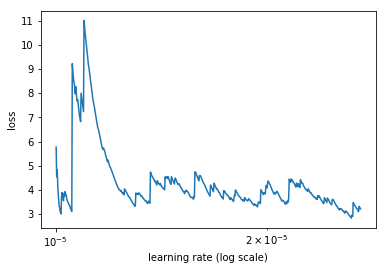

In [96]:
m.sched.plot(1)

In [58]:
m.fit(lr, 3, metrics=[rmse])

 18%|█▊        | 1525/8602 [00:09<00:45, 154.14it/s, loss=3.26]
epoch      trn_loss   val_loss   rmse                          
    0      3.908196   8.240036   0.94976   
    1      2.159406   8.205952   0.949973                      
 34%|███▍      | 2958/8602 [00:19<00:37, 152.52it/s, loss=1.33]

KeyboardInterrupt: 